In [1]:
# !pip install kaggle
# !kaggle competitions download -c spaceship-titanic

import zipfile

import pandas as pd
import numpy as np

from sklearn.preprocessing import LabelEncoder

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style='darkgrid')

In [2]:
with zipfile.ZipFile('spaceship-titanic.zip') as zip:
    zip.printdir()
    zip.extractall(path='data/')

File Name                                             Modified             Size
sample_submission.csv                          2022-02-11 14:02:48        59902
test.csv                                       2022-02-11 14:02:48       372487
train.csv                                      2022-02-11 14:02:48       805421


In [3]:
df_train = pd.read_csv('data/train.csv')
df_test = pd.read_csv('data/test.csv')

print(df_train.shape, df_test.shape)

(8693, 14) (4277, 13)


# EDA

In [4]:
# check for duplicates
print(df_train.duplicated().sum(), df_test.duplicated().sum())

0 0


No duplicate spotted in the original dataset.

In [5]:
# take a peek at the training and test sets
pd.concat([df_train.head(5), df_test.head(5)])

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True
0,0013_01,Earth,True,G/3/S,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,0.0,0.0,Nelly Carsoning,NaN
1,0018_01,Earth,False,F/4/S,TRAPPIST-1e,19.0,False,0.0,9.0,0.0,2823.0,0.0,Lerome Peckers,NaN
2,0019_01,Europa,True,C/0/S,55 Cancri e,31.0,False,0.0,0.0,0.0,0.0,0.0,Sabih Unhearfus,NaN
3,0021_01,Europa,False,C/1/S,TRAPPIST-1e,38.0,False,0.0,6652.0,0.0,181.0,585.0,Meratz Caltilter,NaN
4,0023_01,Earth,False,F/5/S,TRAPPIST-1e,20.0,False,10.0,0.0,635.0,0.0,0.0,Brence Harperez,NaN


---
`PassengerId` - A unique Id for each passenger. Each Id takes the form gggg_pp where gggg indicates a group the passenger is travelling with and pp is their number within the group. People in a group are often family members, but not always.

`HomePlanet` - The planet the passenger departed from, typically their planet of permanent residence.

`CryoSleep` - Indicates whether the passenger elected to be put into suspended animation for the duration of the voyage. Passengers in cryosleep are confined to their cabins.

`Cabin` - The cabin number where the passenger is staying. Takes the form deck/num/side, where side can be either P for Port or S for Starboard.

`Destination` - The planet the passenger will be debarking to.

`Age` - The age of the passenger.

`VIP` - Whether the passenger has paid for special VIP service during the voyage.

`RoomService`, `FoodCourt`, `ShoppingMall`, `Spa`, `VRDeck` - Amount the passenger has billed at each of the Spaceship Titanic's many luxury amenities.

`Name` - The first and last names of the passenger.

`Transported` - Whether the passenger was transported to another dimension. This is the target, the column you are trying to predict.

---

Features that can be extracted from the given data:
- group information -- `PassengerId`
- deck, num and side -- `Cabin`
- family -- `Name`

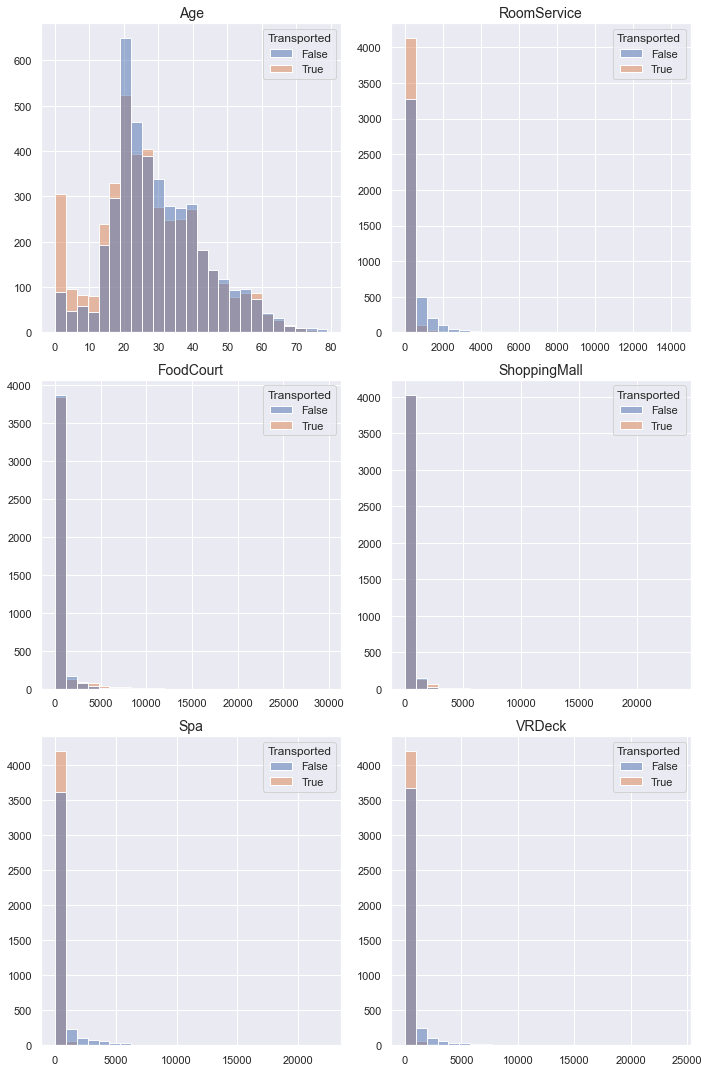

In [6]:
# columns of numerical features
num_cols = ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']

# visualise the relationship between the numerical features and the target
fig, axs = plt.subplots(3, 2, figsize=(10,15))

for i, col in enumerate(num_cols):
    ax = axs[i//2][i%2]
    sns.histplot(data=df_train, x=col, hue='Transported', bins=25, ax=ax)
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_title(col, fontsize=14)

plt.tight_layout()
plt.show()

The distribution of the data for the five amenities were very similar. Most people do not purchase the amenities.

Maybe the five features can be integrated to become one feature representing total spend on all amenities, or become a categorical data suggesting whether a person purchase at any amenity or not.

In [7]:
# taking a closer look at the five amenities
df_train[num_cols[1:]].loc[(df_train[num_cols[1:]]==0).all(axis=1)]

,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0
18,0.0,0.0,0.0,0.0,0.0
19,0.0,0.0,0.0,0.0,0.0
21,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...
8680,0.0,0.0,0.0,0.0,0.0
8681,0.0,0.0,0.0,0.0,0.0
8684,0.0,0.0,0.0,0.0,0.0
8685,0.0,0.0,0.0,0.0,0.0


Nearly half of the passengers did not purchase any of the amenity.

Using a categorical feature to represent it would be better.

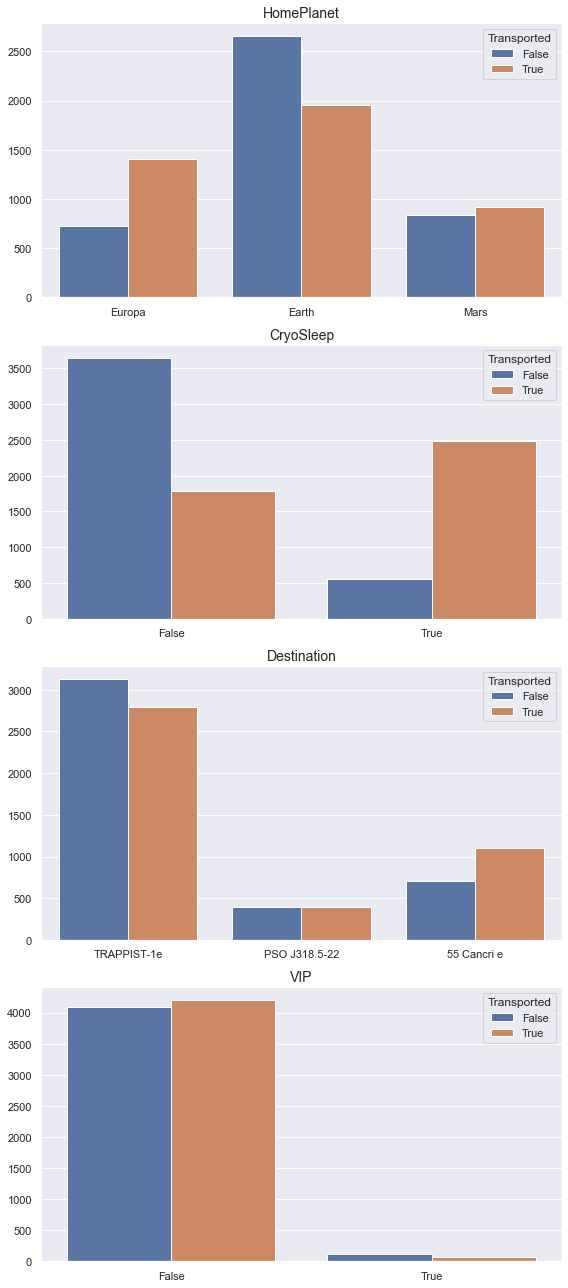

In [8]:
# columns of categorical features
cat_cols = ['HomePlanet', 'CryoSleep', 'Destination', 'VIP']

fig, axs = plt.subplots(4, 1, figsize=(8,18))

for i, col in enumerate(cat_cols):
    ax = axs[i]
    sns.countplot(data=df_train, x=col, hue='Transported', ax=ax)
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_title(col, fontsize=14)

plt.tight_layout()
plt.show()

The `VIP` feature seems to have little relationship with the target, and most people are not VIPs.

Maybe removing it would be better.

In [9]:
# define a function to drop columns (making it easier for later stages)

def drop_col(cols):
    df_train.drop(cols, axis=1, inplace=True)
    df_test.drop(cols, axis=1, inplace=True)

In [10]:
drop_col('VIP')
cat_cols.remove('VIP')

In [11]:
# explore the distribution of the target
df_train['Transported'].value_counts()/df_train.shape[0]

True     0.503624
False    0.496376
Name: Transported, dtype: float64

In [12]:
# inspect data types of all columns
df_train.dtypes

PassengerId      object
HomePlanet       object
CryoSleep        object
Cabin            object
Destination      object
Age             float64
RoomService     float64
FoodCourt       float64
ShoppingMall    float64
Spa             float64
VRDeck          float64
Name             object
Transported        bool
dtype: object

Some columns have problematic data types. We need to take care of them later.

In [13]:
# missing values
print("Total number of missing value in the training set is", sum(df_train.isna().sum()))
print(df_train.isna().sum())

print("\nTotal number of missing value in the test set is", sum(df_test.isna().sum()))
print(df_test.isna().sum())

Total number of missing value in the training set is 2121
PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
dtype: int64

Total number of missing value in the test set is 1024
PassengerId       0
HomePlanet       87
CryoSleep        93
Cabin           100
Destination      92
Age              91
RoomService      82
FoodCourt       106
ShoppingMall     98
Spa             101
VRDeck           80
Name             94
dtype: int64


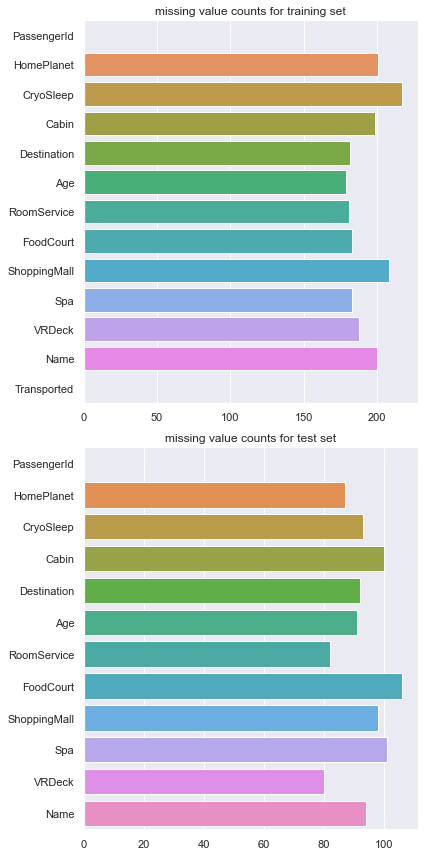

In [14]:
# visualise the count of missing value for each column
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6,12))

sns.barplot(x=df_train.isna().sum().values, y=df_train.columns, ax=ax1)
sns.barplot(x=df_test.isna().sum().values, y=df_test.columns, ax=ax2)

ax1.set_title('missing value counts for training set')
ax2.set_title('missing value counts for test set')

plt.tight_layout()
plt.show()

In [15]:
# number of rows with at least one missing value
na_train = df_train[df_train.isna().any(axis=1)].shape[0]
na_test = df_test[df_test.isna().any(axis=1)].shape[0]

print(f"There are {na_train} ({(na_train / df_train.shape[0] * 100):.2f}%) rows in the training set that have at least one missing value")
print(f"There are {na_test} ({(na_test / df_test.shape[0] * 100):.2f}%) rows in the test set that have at least one missing value")

There are 1922 (22.11%) rows in the training set that have at least one missing value
There are 925 (21.63%) rows in the test set that have at least one missing value


The missing data is quite spread out in all columns.

We need to take care of them according to the data type of each feature. (We will do it later)

# Feature Engineering (creating new features based on existing ones)

## `PassengerId`

In [16]:
# extract group information from PassengerId

df_train['GroupId'] = df_train['PassengerId'].apply(lambda x: x[:4])
df_train['GroupNo'] = df_train['PassengerId'].apply(lambda x: x[5:])

df_test['GroupId'] = df_test['PassengerId'].apply(lambda x: x[:4])
df_test['GroupNo'] = df_test['PassengerId'].apply(lambda x: x[5:])

<AxesSubplot:xlabel='GroupId'>

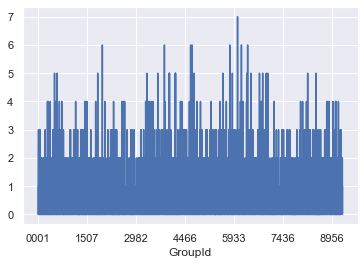

In [17]:
# number of transported passenger in each group
df_train.astype({'Transported': int}).groupby('GroupId').sum()['Transported'].plot()

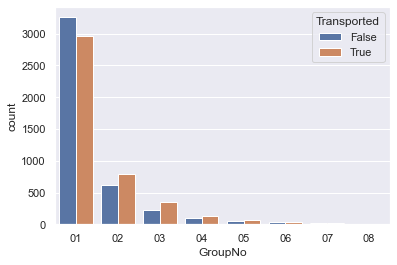

In [18]:
# for each group number
sns.countplot(data=df_train, x='GroupNo', hue='Transported')
plt.show()

The groupid feature can hardly be used for any model, because the number of unique categories is too large.

There is a way to compute it to make use of the group id information. We can know which group each passenger is in and we can also know how many passengers there are in each group. Hence we can create a new feature representing the size of the group a given passenger is in.

In [19]:
# generate a new dataframe containing sizes for all groups
groupsize = pd.concat([df_train['GroupId'], df_test['GroupId']]).value_counts()

# add a new column to represent group size
df_train['GroupSize'] = df_train['GroupId'].apply(lambda x: groupsize[x])
df_test['GroupSize'] = df_test['GroupId'].apply(lambda x: groupsize[x])

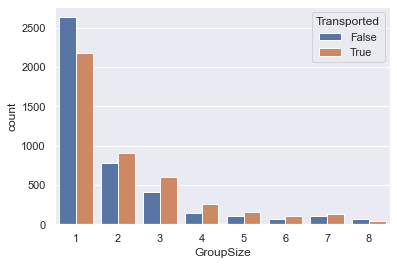

In [20]:
# visualise the distribution of group size data
sns.countplot(data=df_train, x='GroupSize', hue='Transported')
plt.show()

It seems that there are much more passengers in groups with size 1.

Hence we can create a binary categorical feature representing if a passenger is the only member in his/her group.

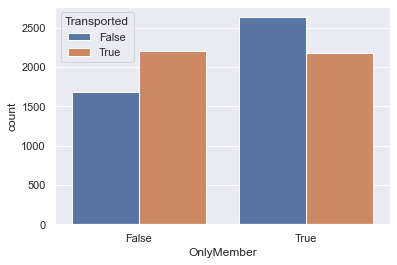

In [21]:
# add binary category for repersenting if a passenger is the only member in a group
df_train['OnlyMember'] = df_train['GroupSize'] == 1
df_test['OnlyMember'] = df_test['GroupSize'] == 1

# visualise its distribution
sns.countplot(data=df_train, x='OnlyMember', hue='Transported')
plt.show()

In [22]:
# discard unnecessary columns
drop_col(['PassengerId', 'GroupId', 'GroupSize'])

## `Cabin`

In [23]:
# temporarily fill the missing values for processing
df_train['Cabin'].fillna('#/#/#', inplace=True)
df_test['Cabin'].fillna('#/#/#', inplace=True)

# extract deck, num and side from Cabin
df_train['CabinDeck'] = df_train['Cabin'].apply(lambda x: x.split('/')[0])
df_train['CabinNum'] = df_train['Cabin'].apply(lambda x: x.split('/')[1])
df_train['CabinSide'] = df_train['Cabin'].apply(lambda x: x.split('/')[2])

df_test['CabinDeck'] = df_test['Cabin'].apply(lambda x: x.split('/')[0])
df_test['CabinNum'] = df_test['Cabin'].apply(lambda x: x.split('/')[1])
df_test['CabinSide'] = df_test['Cabin'].apply(lambda x: x.split('/')[2])

In [24]:
# retrieve the missing values
for col in ['CabinDeck', 'CabinNum', 'CabinSide']:
    df_train.loc[df_train[col] == '#', col] = np.nan
    df_test.loc[df_test[col] == '#', col] = np.nan

In [25]:
# check data types
df_train[['CabinDeck', 'CabinNum', 'CabinSide']].dtypes

CabinDeck    object
CabinNum     object
CabinSide    object
dtype: object

Cabin number data type is problematic.

In [26]:
# set correct data type (Num has to be float because np.nan cannot be convert to integer type)
# we will deal with the missing values later
df_train['CabinNum'] = df_train['CabinNum'].astype(float)
df_test['CabinNum'] = df_test['CabinNum'].astype(float)

In [27]:
# check unique values for each column
df_train[['CabinDeck', 'CabinNum', 'CabinSide']].nunique()

CabinDeck       8
CabinNum     1817
CabinSide       2
dtype: int64

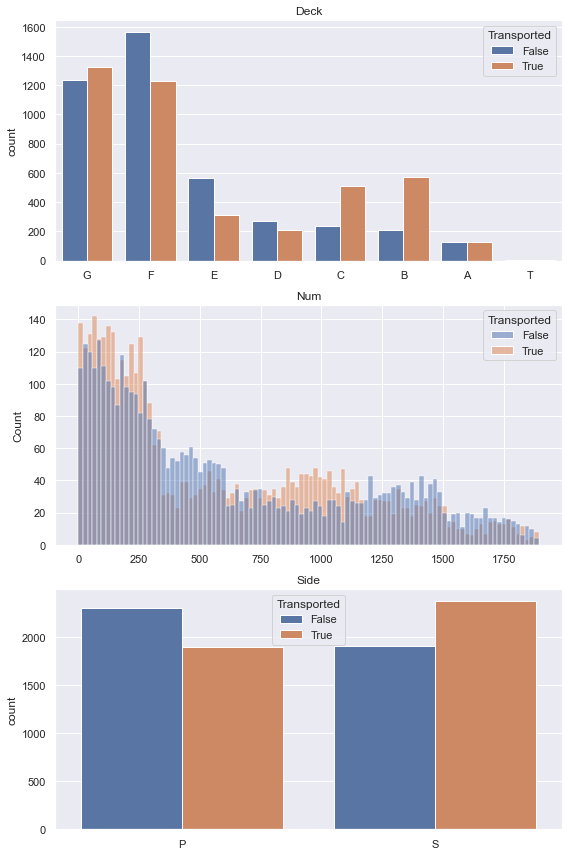

In [28]:
# visualise the distributions of cabin deck, cabin number and cabin side data
fig = plt.figure(figsize=(8,12))

plt.subplot(3,1,1)
sns.countplot(data=df_train, x='CabinDeck', hue='Transported', order=['G','F','E','D','C','B','A','T'])
plt.xlabel('')
plt.title('Deck')

plt.subplot(3,1,2)
sns.histplot(data=df_train, x='CabinNum', hue='Transported', bins=100)
plt.xlabel('')
plt.title('Num')

plt.subplot(3,1,3)
sns.countplot(data=df_train, x='CabinSide', hue='Transported')
plt.xlabel('')
plt.title('Side')

plt.tight_layout()
plt.show()

The cabin number shows some clear decrease in the counts of total passengers. 0~300 has the most passengers, 300~600 has significantly fewer passengers. 600~1500 has further lower number. And 1500 onward has the fewest passengers.

Hence we can probably use intervals with 300 (categorical data) rather than continuous data.

In [29]:
df_train['CabinNumInterval'] = pd.Series(str)
df_test['CabinNumInterval'] = pd.Series(str)

df_train.loc[df_train['CabinNum'] < 300, 'CabinNumInterval'] = '< 300'
df_test.loc[df_test['CabinNum'] < 300, 'CabinNumInterval'] = '< 300'

df_train.loc[(df_train['CabinNum'] >= 300) & (df_train['CabinNum'] < 600), 'CabinNumInterval'] = '300 ~ 600'
df_test.loc[(df_test['CabinNum'] >= 300) & (df_test['CabinNum'] < 600), 'CabinNumInterval'] = '300 ~ 600'

df_train.loc[(df_train['CabinNum'] >= 600) & (df_train['CabinNum'] < 900), 'CabinNumInterval'] = '600 ~ 900'
df_test.loc[(df_test['CabinNum'] >= 600) & (df_test['CabinNum'] < 900), 'CabinNumInterval'] = '600 ~ 900'

df_train.loc[(df_train['CabinNum'] >= 900) & (df_train['CabinNum'] < 1200), 'CabinNumInterval'] = '900 ~ 1200'
df_test.loc[(df_test['CabinNum'] >= 900) & (df_test['CabinNum'] < 1200), 'CabinNumInterval'] = '900 ~ 1200'

df_train.loc[(df_train['CabinNum'] >= 1200) & (df_train['CabinNum'] < 1500), 'CabinNumInterval'] = '1200 ~ 1500'
df_test.loc[(df_test['CabinNum'] >= 1200) & (df_test['CabinNum'] < 1500), 'CabinNumInterval'] = '1200 ~ 1500'

df_train.loc[df_train['CabinNum'] >= 1500, 'CabinNumInterval'] = '>= 1500'
df_test.loc[df_test['CabinNum'] >= 1500, 'CabinNumInterval'] = '>= 1500'

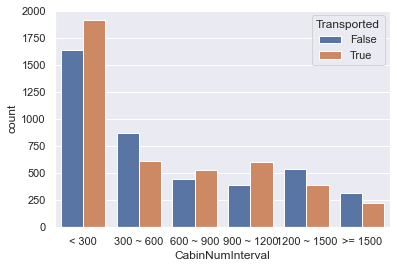

In [30]:
# check distribution
sns.countplot(data=df_train, x='CabinNumInterval', hue='Transported')
plt.show()

In [31]:
drop_col(['Cabin','CabinNum'])

## `Name`

In [32]:
# fill the missing values for processing
df_train['Name'].fillna('nan nan', inplace=True)
df_test['Name'].fillna('nan nan', inplace=True)

# extract family name information
df_train['FamilyName'] = df_train['Name'].apply(lambda x: x.split(' ')[1])
df_test['FamilyName'] = df_test['Name'].apply(lambda x: x.split(' ')[1])

In [33]:
# Number of unique values in FamilyName
df_train['FamilyName'].value_counts()

nan           200
Casonston      18
Oneiles        16
Domington      15
Litthews       15
             ... 
Covale          1
Dun             1
Witalnerod      1
Deryplinet      1
Sionerorly      1
Name: FamilyName, Length: 2218, dtype: int64

Obviously this cannot be used as a feature for the model.

We can create another feature representing how many people in the same family are on the spaceship. (that's the size of the family for each passenger)

Maybe passengers with a larger family have higher probability to be transported.

In [34]:
# count number of people in each family
familysize = pd.concat([df_train, df_test])['FamilyName'].value_counts()

# create a new column containing sizes of family
df_train['FamilySize'] = df_train['FamilyName'].apply(lambda x: familysize[x])
df_test['FamilySize'] = df_test['FamilyName'].apply(lambda x: familysize[x])

In [35]:
# check unique family size values
df_train['FamilySize'].value_counts()

6      1009
5       979
7       974
4       805
9       763
8       753
3       616
10      583
11      441
2       425
12      344
14      208
294     200
13      165
1       133
15       98
16       94
18       43
17       38
19       22
Name: FamilySize, dtype: int64

In [36]:
df_train[df_train['FamilySize'] == 294].head()

,HomePlanet,CryoSleep,Destination,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,GroupNo,OnlyMember,CabinDeck,CabinSide,CabinNumInterval,FamilyName,FamilySize
27,Mars,False,TRAPPIST-1e,21.0,980.0,2.0,69.0,0.0,0.0,nan nan,False,01,True,D,P,< 300,nan,294
58,Mars,True,TRAPPIST-1e,15.0,0.0,0.0,0.0,0.0,0.0,nan nan,True,01,False,F,S,< 300,nan,294
65,Earth,False,TRAPPIST-1e,42.0,887.0,0.0,9.0,6.0,0.0,nan nan,True,01,True,F,S,< 300,nan,294
77,Mars,False,TRAPPIST-1e,8.0,0.0,0.0,0.0,0.0,0.0,nan nan,True,03,False,F,P,< 300,nan,294
101,Earth,False,TRAPPIST-1e,31.0,562.0,0.0,326.0,0.0,0.0,nan nan,False,02,False,G,S,< 300,nan,294


There is a size of 294 which is the place for 'nan' (missing value).

In [37]:
# retrieve the missing value
df_train.loc[df_train['FamilySize'] == 294, 'FamilySize'] = np.nan
df_test.loc[df_test['FamilyName'] == 'nan', 'FamilySize'] = np.nan

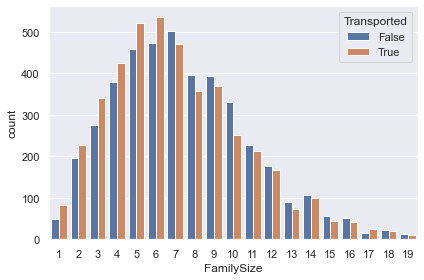

In [38]:
# visualise the distribution of family size
sns.countplot(data=df_train, x='FamilySize', hue='Transported')
plt.xticks(ticks=range(19), labels=range(1,20))
plt.tight_layout()
plt.show()

In [39]:
drop_col(['Name', 'FamilyName'])

## Amenities

We can combine the five amenities to one feature, because many people did not pay for any of these.

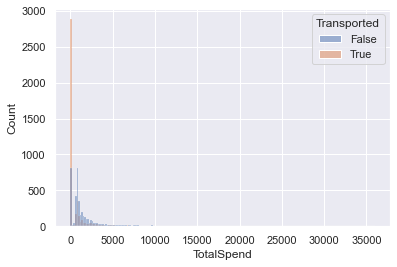

In [40]:
# create a total sepnd column
df_train['TotalSpend'] = df_train[num_cols[1:]].sum(axis=1)
df_test['TotalSpend'] = df_test[num_cols[1:]].sum(axis=1)

# inspect the distribution of it
sns.histplot(data=df_train, x='TotalSpend', hue='Transported', bins=200)
plt.show()

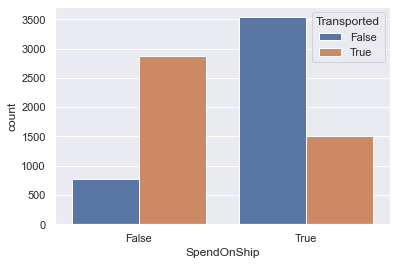

In [41]:
# create binary categorical data for pay/not pay for any amenity
df_train['SpendOnShip'] = df_train['TotalSpend'] > 0
df_test['SpendOnShip'] = df_test['TotalSpend'] > 0

# visualise the distribution
sns.countplot(data=df_train, x='SpendOnShip', hue='Transported')
plt.show()

In [42]:
drop_col(num_cols[1:]+['TotalSpend'])

# Data cleaning

In [43]:
# check data types
print(df_train.dtypes, '\n')
print(df_test.dtypes)

HomePlanet           object
CryoSleep            object
Destination          object
Age                 float64
Transported            bool
GroupNo              object
OnlyMember             bool
CabinDeck            object
CabinSide            object
CabinNumInterval     object
FamilySize          float64
SpendOnShip            bool
dtype: object 

HomePlanet           object
CryoSleep            object
Destination          object
Age                 float64
GroupNo              object
OnlyMember             bool
CabinDeck            object
CabinSide            object
CabinNumInterval     object
FamilySize          float64
SpendOnShip            bool
dtype: object


The data type of `GroupNo` is problematic. It should be integer type instead of object.

In [44]:
# convert the data type to integer
df_train['GroupNo'] = df_train['GroupNo'].astype(int)
df_test['GroupNo'] = df_test['GroupNo'].astype(int)

In [45]:
# check for missing values (because many new features have been added)
print("Total number of missing value in the training set is", sum(df_train.isna().sum()))
print(df_train.isna().sum())

print("\nTotal number of missing value in the test set is", sum(df_test.isna().sum()))
print(df_test.isna().sum())

Total number of missing value in the training set is 1576
HomePlanet          201
CryoSleep           217
Destination         182
Age                 179
Transported           0
GroupNo               0
OnlyMember            0
CabinDeck           199
CabinSide           199
CabinNumInterval    199
FamilySize          200
SpendOnShip           0
dtype: int64

Total number of missing value in the test set is 757
HomePlanet           87
CryoSleep            93
Destination          92
Age                  91
GroupNo               0
OnlyMember            0
CabinDeck           100
CabinSide           100
CabinNumInterval    100
FamilySize           94
SpendOnShip           0
dtype: int64


The proposed approach is to use median of each column to impute missing values for numerical feature, and to use mode for categorical feature.

In [46]:
# use median to impute missing values for numerical data (can also use SimpleImputer in skilearn module)
num_cols = ['Age', 'FamilySize']
for col in num_cols:
    df_train[col].fillna(df_train[col].median(), inplace=True)
    df_test[col].fillna(df_test[col].median(), inplace=True)

In [47]:
# use mode to impute missing values for categorical features
cat_cols = ['HomePlanet', 'CryoSleep', 'Destination', 'CabinDeck', 'CabinSide', 'CabinNumInterval']
for col in cat_cols:
    df_train[col].fillna(df_train[col].mode()[0], inplace=True)
    df_test[col].fillna(df_test[col].mode()[0], inplace=True)

In [48]:
# check for missing values after the imputation
print("Total number of missing value in the training set is", sum(df_train.isna().sum()))
print(df_train.isna().sum())

print("\nTotal number of missing value in the test set is", sum(df_test.isna().sum()))
print(df_test.isna().sum())

Total number of missing value in the training set is 0
HomePlanet          0
CryoSleep           0
Destination         0
Age                 0
Transported         0
GroupNo             0
OnlyMember          0
CabinDeck           0
CabinSide           0
CabinNumInterval    0
FamilySize          0
SpendOnShip         0
dtype: int64

Total number of missing value in the test set is 0
HomePlanet          0
CryoSleep           0
Destination         0
Age                 0
GroupNo             0
OnlyMember          0
CabinDeck           0
CabinSide           0
CabinNumInterval    0
FamilySize          0
SpendOnShip         0
dtype: int64


In [49]:
# check data types
df_train.dtypes

HomePlanet           object
CryoSleep              bool
Destination          object
Age                 float64
Transported            bool
GroupNo               int32
OnlyMember             bool
CabinDeck            object
CabinSide            object
CabinNumInterval     object
FamilySize          float64
SpendOnShip            bool
dtype: object

`Age` and `FamilySize` should both be interger type.

In [50]:
# convert data type to integer
df_train[['Age', 'FamilySize']] = df_train[['Age', 'FamilySize']].astype(int)
df_test[['Age', 'FamilySize']] = df_test[['Age', 'FamilySize']].astype(int)

# and recheck
df_train.dtypes

HomePlanet          object
CryoSleep             bool
Destination         object
Age                  int32
Transported           bool
GroupNo              int32
OnlyMember            bool
CabinDeck           object
CabinSide           object
CabinNumInterval    object
FamilySize           int32
SpendOnShip           bool
dtype: object

There is now no missing value and the data types are all correct.

# Data pre-processing

In [51]:
num_cols, cat_cols = [], []
for col_name in df_test.columns:
    if df_train.dtypes[col_name] == int:
        num_cols.append(col_name)
    else:
        cat_cols.append(col_name)

print("Numerical features: ", num_cols)
print("Categorical features: ", cat_cols)

Numerical features:  ['Age', 'GroupNo', 'FamilySize']
Categorical features:  ['HomePlanet', 'CryoSleep', 'Destination', 'OnlyMember', 'CabinDeck', 'CabinSide', 'CabinNumInterval', 'SpendOnShip']


Note that although the data type of group number `GroupNo` is integer, it should actually be treated as a categorical data because the number itself doesn't have numerical meanings but rather act as a label.

In [52]:
# GroupNo should be categorical feature
num_cols.remove('GroupNo')
cat_cols.append('GroupNo')

The numerical features need to be scaled and the categorical features need to be encoded.

But before that, we need to check the distribution of the numerical data to ensure a normal-like structure of the data.

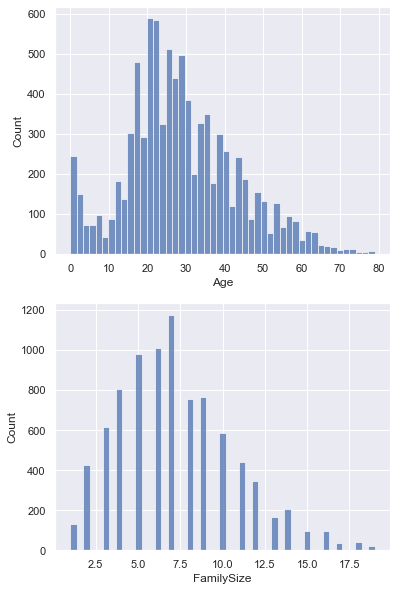

In [53]:
# check distributions of the numerical data
fig = plt.figure(figsize=(6, 10))

for i, col in enumerate(num_cols):
    plt.subplot(2, 1, i+1)
    sns.histplot(data=df_train, x=col)

plt.show()

They both have fairly normal distribution. Hence we do not need to perform a transformation.

In [54]:
# use LabelEncoder to encode categorical values
le = LabelEncoder()

# create a dictionary to memorise the pairs of all the categories with the corresponding labels (for looking up the meaning of the label)
label_memo = {}

for col in cat_cols:
    uniq_cat = np.union1d(df_train[col].unique(), df_test[col].unique())
    le.fit(uniq_cat)
    
    # add memo
    memo = {}
    for i, cat in enumerate(uniq_cat):
        memo[le.transform(uniq_cat)[i]] = cat
    label_memo[col] = memo
    
    # encode the column
    df_train[col] = le.transform(df_train[col])
    df_test[col] = le.transform(df_test[col])

In [55]:
# an example of looking up a label
# say I want to know what it means for a 1 for the CabinNumInterval feature
label_memo['CabinNumInterval'][1]

'300 ~ 600'

In [56]:
# also encode the target variable
le.fit([True, False])
temp_memo = {}

for i, cat in enumerate([True, False]):
    temp_memo[le.transform([True, False])[i]] = cat
label_memo['Transported'] = temp_memo

# encode the column
df_train['Transported'] = le.transform(df_train['Transported'])

In [57]:
df_train.dtypes

HomePlanet          int32
CryoSleep           int64
Destination         int32
Age                 int32
Transported         int64
GroupNo             int64
OnlyMember          int64
CabinDeck           int32
CabinSide           int32
CabinNumInterval    int32
FamilySize          int32
SpendOnShip         int64
dtype: object

In [ ]:
df_train[['PassengerId', 'HomePlanet', 'Cabin','Destination','Name']] = df_train[['PassengerId', 'HomePlanet', 'Cabin','Destination','Name']].astype(str)
df_train[['CryoSleep', 'VIP']] = df_train[['CryoSleep', 'VIP']].astype(bool)

df_train.dtypes